In [88]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [127]:
# import system_message.txt as a string
with open('prompts/system_message.txt', 'r') as file:
    system_message = file.read()

print(system_message)

Context:
You are an advanced AI language model trained to analyze financial documents. Your task is to analyze the last earnings call transcripts before default of companies and extract specific textual features, sentiment scores, and key financial metrics. These features will be used to predict the recovery rate of bonds, defined as the 30-day average bond price after default, issued by these companies.

Objective:
Given the provided earnings call transcript, perform the following tasks:

Extract Financial Sentiment Scores:
Evaluate the financial sentiment expressed throughout the earnings call using the following unique categories:
[Score1] Negative Sentiment (0.00-1.00): Measure the extent of negative financial language (e.g., risks, losses, challenges, declining revenues, increased expenses). A score closer to 1 indicates a highly negative financial tone.
[Score2] Positive Sentiment (0.00-1.00): Assess the presence of positive financial language (e.g., growth, profits, opportunitie

In [90]:
transcripts = pd.read_csv('transcripts/credit_df.csv', delimiter='|')

# count unique transcripts in transcripts['Cleaned_Bankruptcy_Indicators']
print(transcripts['presentation_cleaned'].nunique())

# count rows where presentation_cleaned is ''
print(transcripts['presentation_cleaned'].isnull().sum())

# drop rows where presentation_cleaned is ''
transcripts = transcripts.dropna(subset=['presentation_cleaned'])

# add a number to each transcript based on the 196 unique transcripts
transcripts['transcript_number'] = transcripts['presentation_cleaned'].factorize()[0]

number_transcript = transcripts[['transcript_number', 'presentation_cleaned']].drop_duplicates().sort_values('transcript_number')

number_transcript.head()

193
3


,transcript_number,presentation_cleaned
0,0,"as you know, on september 18th, kellwood recei..."
1,1,"secondly, we're going to be\nallowing one ques..."
2,2,frontier assumes\nno obligation to update this...
3,3,"with me\ntoday are; dick bond, our president a..."
4,4,bob will then\nreview the financial performanc...


In [140]:
transcripts = pd.read_csv('transcripts/credit_df.csv', delimiter='|')

# drop rows where presentation_cleaned is ''
transcripts = transcripts.dropna(subset=['QnA'])

# add a number to each transcript based on the 196 unique transcripts
transcripts['transcript_number'] = transcripts['QnA'].factorize()[0]

number_transcript = transcripts[['transcript_number', 'QnA']].drop_duplicates().sort_values('transcript_number')

number_transcript.head()

,transcript_number,QnA
0,0,question and answer\noperator\n[operator instr...
1,1,question and answer\noperator\n(operator instr...
2,2,question and answer\noperator\nthank you. ladi...
3,3,question and answer\noperator\n[operator instr...
4,4,question and answer\noperator\n(operator instr...


In [141]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)

output = []

In [142]:
for i in number_transcript['QnA']:
    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0,
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": i}
            ]
        )
        output.append(completion.choices[0].message.content)
        print(len(output))
        print(completion.choices[0].message.content)
    except openai.error.OpenAIError as e:
        print(f"An exception occurred: {e}")
        print("Waiting for 1 minute before retrying...")
        time.sleep(60)


1
0.75; 0.25; 0.60; 0.50; 0.30; 0.40; 0.45; 0.50; 0.40; 0.60; 0.30
2
0.75; 0.25; 0.50; 0.60; 0.40; 0.50; 0.30; 0.40; 0.30; 0.60; 0.50
3
0.75; 0.25; 0.60; 0.40; 0.50; 0.45; 0.55; 0.70; 0.50; 0.60; 0.40
4
0.85; 0.15; 0.90; 0.60; 0.50; 0.40; 0.30; 0.50; 0.40; 0.70; 0.35
5
0.75; 0.25; 0.50; 0.40; 0.30; 0.50; 0.45; 0.60; 0.50; 0.55; 0.40
6
0.76; 0.24; 0.67; 0.58; 0.45; 0.50; 0.60; 0.70; 0.55; 0.65; 0.40
7
0.62; 0.25; 0.70; 0.55; 0.40; 0.35; 0.45; 0.60; 0.30; 0.50; 0.30
8
0.75; 0.25; 0.65; 0.30; 0.45; 0.40; 0.50; 0.60; 0.20; 0.35; 0.25
9
0.88; 0.12; 0.74; 0.40; 0.30; 0.45; 0.35; 0.20; 0.10; 0.65; 0.60
10
0.75; 0.25; 0.50; 0.70; 0.60; 0.50; 0.55; 0.50; 0.60; 0.65; 0.70
11
0.60; 0.40; 0.50; 0.70; 0.30; 0.50; 0.40; 0.35; 0.20; 0.60; 0.50
12
0.78; 0.22; 0.65; 0.70; 0.62; 0.50; 0.54; 0.66; 0.60; 0.73; 0.45
13
0.60; 0.30; 0.50; 0.70; 0.50; 0.60; 0.65; 0.40; 0.50; 0.55; 0.30
14
0.75; 0.25; 0.60; 0.40; 0.30; 0.50; 0.45; 0.60; 0.50; 0.40; 0.30
15
0.78; 0.22; 0.68; 0.45; 0.60; 0.50; 0.55; 0.70; 0.50; 

In [143]:
# Initialize the DataFrame with the new columns
output_df = pd.DataFrame(columns=[
    'negative', 'positive', 'uncertainty',
    'liquidity_concerns', 'debt_leverage_stress', 'operational_challenges', 'macroeconomic_pressures',
    'asset_quality', 'recovery_strategies', 'management_confidence_distress', 'overall_distress_level'
])

# Parse the output list and populate the DataFrame
output_df['negative'] = [float(i.split('; ')[0]) for i in output]
output_df['positive'] = [float(i.split('; ')[1]) for i in output]
output_df['uncertainty'] = [float(i.split('; ')[2]) for i in output]
output_df['liquidity_concerns'] = [float(i.split('; ')[3]) for i in output]
output_df['debt_leverage_stress'] = [float(i.split('; ')[4]) for i in output]
output_df['operational_challenges'] = [float(i.split('; ')[5]) for i in output]
output_df['macroeconomic_pressures'] = [float(i.split('; ')[6]) for i in output]
output_df['asset_quality'] = [float(i.split('; ')[7]) for i in output]
output_df['recovery_strategies'] = [float(i.split('; ')[8]) for i in output]
output_df['management_confidence_distress'] = [float(i.split('; ')[9]) for i in output]
output_df['overall_distress_level'] = [float(i.split('; ')[10]) for i in output]

# Display the DataFrame
output_df


,negative,positive,uncertainty,liquidity_concerns,debt_leverage_stress,operational_challenges,macroeconomic_pressures,asset_quality,recovery_strategies,management_confidence_distress,overall_distress_level
0,0.75,0.25,0.6,0.5,0.3,0.40,0.45,0.50,0.40,0.60,0.30
1,0.75,0.25,0.5,0.6,0.4,0.50,0.30,0.40,0.30,0.60,0.50
2,0.75,0.25,0.6,0.4,0.5,0.45,0.55,0.70,0.50,0.60,0.40
3,0.85,0.15,0.9,0.6,0.5,0.40,0.30,0.50,0.40,0.70,0.35
4,0.75,0.25,0.5,0.4,0.3,0.50,0.45,0.60,0.50,0.55,0.40
...,...,...,...,...,...,...,...,...,...,...,...
191,0.65,0.25,0.6,0.6,0.5,0.40,0.50,0.40,0.30,0.50,0.40
192,0.70,0.30,0.8,0.6,0.4,0.50,0.55,0.45,0.65,0.50,0.40
193,0.35,0.40,0.5,0.6,0.7,0.55,0.60,0.45,0.50,0.65,0.55
194,0.80,0.20,0.6,0.4,0.2,0.30,0.30,0.50,0.30,0.40,0.50


In [150]:
output_df['transcript_number'] = output_df.index

# merge output_df with transcripts on 'transcript_number' and index
transcripts = pd.merge(transcripts,
                          output_df,
                          on='transcript_number',
                          how='left')

checkpoint = transcripts.copy()

In [151]:
# save checkpoint as csv
checkpoint.to_csv('transcripts/LLM_outputs_QnA.csv', index=False)
checkpoint = pd.read_csv('transcripts/LLM_outputs_QnA.csv')

In [145]:
# List of selected supporting features
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

llm_labels = ['negative', 'positive', 'uncertainty',
    'liquidity_concerns', 'debt_leverage_stress', 'operational_challenges', 'macroeconomic_pressures',
    'asset_quality', 'recovery_strategies', 'management_confidence_distress', 'overall_distress_level']

# Select the supporting features, nlp_lables, and RR from final_df
final_df = checkpoint[['Date'] 
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + llm_labels 
                    + ['RR']]

# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
final_df.replace('#DIV/0!', np.nan, inplace=True)
final_df = final_df.fillna(0)

# make sure all values are numeric except for the Date column
final_df = final_df.apply(pd.to_numeric, errors='ignore')

final_df.head()

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Date,negative,positive,uncertainty,liquidity_concerns,debt_leverage_stress,operational_challenges,macroeconomic_pressures,asset_quality,recovery_strategies,management_confidence_distress,overall_distress_level,RR
0,2006-12-01,0.75,0.25,0.6,0.5,0.3,0.40,0.45,0.5,0.4,0.60,0.30,29.023972
1,2007-11-06,0.75,0.25,0.5,0.6,0.4,0.50,0.30,0.4,0.3,0.60,0.50,8.869420
2,2008-01-25,0.75,0.25,0.6,0.4,0.5,0.45,0.55,0.7,0.5,0.60,0.40,33.210455
3,2008-01-28,0.85,0.15,0.9,0.6,0.5,0.40,0.30,0.5,0.4,0.70,0.35,11.875000
4,2008-01-30,0.75,0.25,0.5,0.4,0.3,0.50,0.45,0.6,0.5,0.55,0.40,18.340000


In [146]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR', 'Date']), final_df.drop(columns=['RR', 'Date'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     84.11
Date:                Mon, 30 Sep 2024   Prob (F-statistic):          3.12e-235
Time:                        14:30:16   Log-Likelihood:                -4416.0
No. Observations:                1075   AIC:                             8886.
Df Residuals:                    1048   BIC:                             9020.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

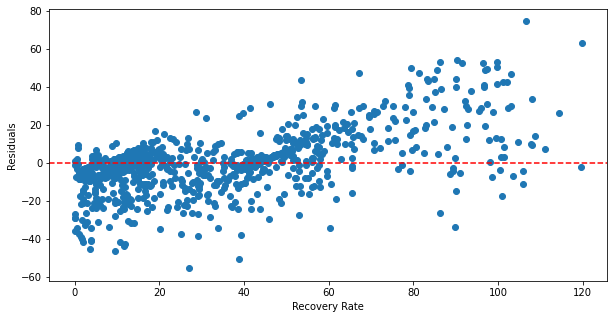

In [48]:
# Bond data 1 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [42]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
0                                      const  3451.497473
17                                Financials    16.518393
24                                  positive    16.019196
23                                  negative    13.746078
11                      ActIndustryDistress1     9.552753
36                                      tone     8.868641
2                    NASDAQ 100 Index return     8.830704
34                                management     7.796101
4         30 year conventional mortgage rate     7.093185
3   Manufacturers inventories to sales ratio     6.500186
28                                      weak     6.282308
1                 CBOE DJIA Volatility Index     5.721469
27                                    strong     5.595985
18                                    Energy     5.240345
38                                confidence     5.201854
12                      ActIndustryDistress2     4.788685
37            

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     56.21
Date:                Wed, 04 Sep 2024   Prob (F-statistic):          2.17e-248
Time:                        18:19:51   Log-Likelihood:                -4337.4
No. Observations:                1075   AIC:                             8771.
Df Residuals:                    1027   BIC:                             9010.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

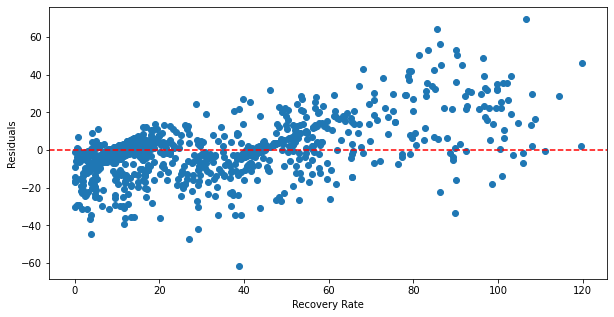

In [16]:
# Bond data 2 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [17]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
0                                      const  4053.917229
28                                  positive    19.400475
17                                Financials    18.662614
27                                  negative    15.291854
40                                      tone    10.419252
11                      ActIndustryDistress1    10.356115
2                    NASDAQ 100 Index return     9.552461
38                                management     8.798866
4         30 year conventional mortgage rate     8.103863
3   Manufacturers inventories to sales ratio     7.831635
42                                confidence     6.871037
32                                      weak     6.769769
1                 CBOE DJIA Volatility Index     6.471550
31                                    strong     5.816200
18                                    Energy     5.609114
41                            forwardlooking     5.034346
6             

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     64.78
Date:                Mon, 30 Sep 2024   Prob (F-statistic):          2.27e-110
Time:                        22:22:45   Log-Likelihood:                -4746.0
No. Observations:                1075   AIC:                             9516.
Df Residuals:                    1063   BIC:                             9576.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

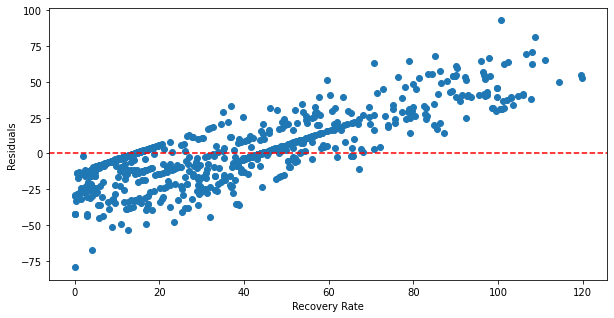

In [147]:
# LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [148]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                          Features         VIF
0                            const  204.711974
4               liquidity_concerns    4.860243
5             debt_leverage_stress    4.789591
6           operational_challenges    3.824678
10  management_confidence_distress    2.942738
7          macroeconomic_pressures    2.547444
9              recovery_strategies    2.401388
1                         negative    2.394326
2                         positive    2.377799
8                    asset_quality    2.327582
3                      uncertainty    2.302486
11          overall_distress_level    1.722572


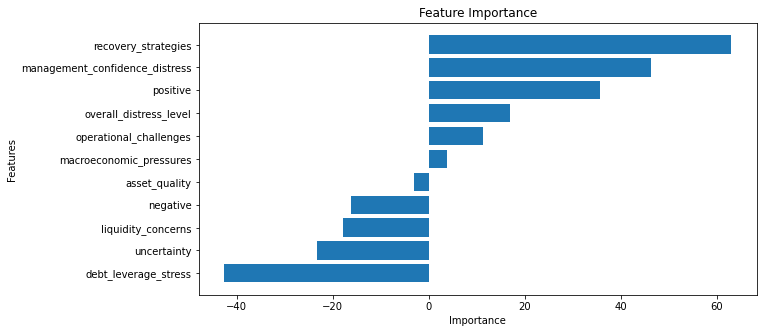

In [149]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()